## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
from matplotlib.colors import LogNorm

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
modver='HC1905'
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2017,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
rematch=True
if rematch==True:
    df1=et.loadDFOCTD()
    df1.head()

In [3]:

saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/'
fname=f'data_DFOCTD_{modver}_{start_date.strftime("%Y%m%d")}_{end_date.strftime("%Y%m%d")}'
if rematch==True:
    data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
    pickle.dump(data,open(os.path.join(saveloc,fname)+'.pkl','wb'))
else:
    data=pickle.load(open(os.path.join(saveloc,fname)+'.pkl','rb'))

(Lat,Lon)= 48.95583333333333 -125.10966666666667  not matched to domain
(Lat,Lon)= 48.963 -125.115  not matched to domain
(Lat,Lon)= 48.96383333333333 -125.1145  not matched to domain
(Lat,Lon)= 48.964666666666666 -125.12581666666667  not matched to domain
(Lat,Lon)= 49.01083333333333 -125.17  not matched to domain
(Lat,Lon)= 49.011 -125.17083333333333  not matched to domain
(Lat,Lon)= 49.01116666666667 -125.17  not matched to domain
(Lat,Lon)= 49.01133333333333 -125.17033333333333  not matched to domain
(Lat,Lon)= 49.01133333333333 -125.17  not matched to domain
(Lat,Lon)= 49.020833333333336 -125.1565  not matched to domain
(Lat,Lon)= 49.021 -125.157  not matched to domain
(Lat,Lon)= 49.021 -125.15666666666667  not matched to domain
(Lat,Lon)= 49.021 -125.1565  not matched to domain
(Lat,Lon)= 49.021 -125.15616666666666  not matched to domain
(Lat,Lon)= 49.029333333333334 -125.15333333333334  not matched to domain
(Lat,Lon)= 49.0295 -125.15266666666666  not matched to domain
(Lat,Lon)

In [4]:
data.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,dtUTC,j,i,mod_vosaline,mod_votemper,k
0,2013.0,1.0,10.0,17.118056,49.329667,-124.081,0.892338,27.814801,6.753649,NaN,2013-01-10 17:07:05,526,206,28.452301,7.408990,0
1,2013.0,1.0,10.0,17.118056,49.329667,-124.081,1.883821,27.826002,6.762110,NaN,2013-01-10 17:07:05,526,206,28.452488,7.410102,1
2,2013.0,1.0,10.0,17.118056,49.329667,-124.081,2.974446,27.842222,6.764341,NaN,2013-01-10 17:07:05,526,206,28.452883,7.411254,2
3,2013.0,1.0,10.0,17.118056,49.329667,-124.081,4.065065,27.901148,6.812357,NaN,2013-01-10 17:07:05,526,206,28.454327,7.413784,4
4,2013.0,1.0,10.0,17.118056,49.329667,-124.081,4.957386,28.036150,6.874438,NaN,2013-01-10 17:07:05,526,206,28.454327,7.413784,4


In [5]:
# save pickle as csv for TJ:
data.to_csv(os.path.join(saveloc,fname)+'.csv',index=False)

In [6]:
print(os.path.join(saveloc,fname)+'.csv')

/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/data_DFOCTD_HC1905_20130101_20170101.csv


In [7]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [8]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

##### Apply cluster information

In [9]:
cver = "BIO"
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cfile = {2013:"BIO_clno_5_2013_reass.pkl",2014:"BIO_clno_5_2014_reass.pkl", 
         2015: "BIO_clno_5_2015_reass.pkl", 2016: "BIO_clno_5_2016_reass.pkl"}
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
print('Cluster version is:', cver)
# papermill reads dictionary keys as strings, so add code to correct this
cfile2=dict()
for key,val in cfile.items():
    cfile2[int(key)]=val
cfile=cfile2
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

data['Cluster']=np.zeros(len(data))
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

Cluster version is: BIO


In [10]:
for el in cf.keys():
    print(np.unique(cf[el]))

[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]


In [11]:
np.unique(data['Cluster'])

array([0., 1., 2., 3., 4., 5.])

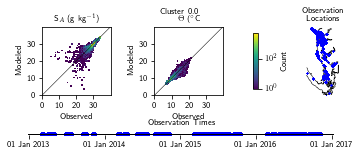

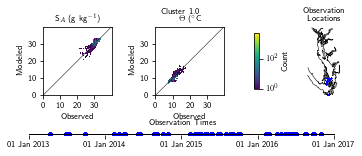

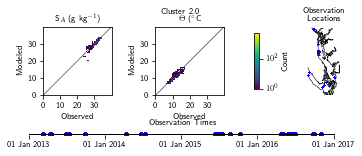

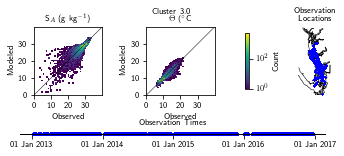

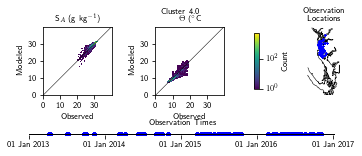

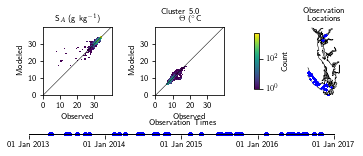

In [12]:
for ic in np.unique(data['Cluster']):
    bounds = np.array([0,5,10,15,20,40,100,200,450])
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    #pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
    tm=40
    sm=40

    fig = plt.figure(figsize = (5,2.))
    gsv = gridspec.GridSpec(2,1,left=.08,right=.98,hspace=1,bottom=.1,top=.85,height_ratios=[4,.2])
    gs1=gridspec.GridSpecFromSubplotSpec(1,5,subplot_spec=gsv[0],wspace=.3,hspace=.34,
                                         width_ratios=[1,1,.05,.05,.6])
    axSA = fig.add_subplot(gs1[0])
    axCT = fig.add_subplot(gs1[1])
    axLmap = fig.add_subplot(gs1[-1])

    gscb = gridspec.GridSpecFromSubplotSpec(11,1,subplot_spec=gs1[2])
    axcb = fig.add_subplot(gscb[1:-1])

    axL=fig.add_subplot(gsv[1])

    axSA.plot((0,sm),(0,sm),'k-',lw=.5)
    axCT.plot((0,tm),(0,tm),'k-',lw=.5)

    vm0=-150
    args={'marker':'.','s':1,'norm':norm}
    dataCl=data.loc[(data.Cluster==ic)]
    #ps=et.varvarScatter(axSA,dataCl,'SA','mod_vosaline','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    #ps=et.varvarScatter(axCT,dataCl,'CT','mod_votemper','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    
    iiT=(~np.isnan(dataCl['CT']))&(~np.isnan(dataCl['mod_votemper']))
    iiS=(~np.isnan(dataCl['SA']))&(~np.isnan(dataCl['mod_vosaline']))
    counts, xedges, yedges, m1=axCT.hist2d(dataCl.loc[iiT,['CT']].values.flatten(),
                                          dataCl.loc[iiT,['mod_votemper']].values.flatten(),bins=25*3,norm=LogNorm(vmin=1,vmax=5*10**3),
                                           cmin=1,cmax=5*10**3)
    counts, xedges, yedges, m2=axSA.hist2d(dataCl.loc[iiS,['SA']].values.flatten(),
                                          dataCl.loc[iiS,['mod_vosaline']].values.flatten(),bins=25*3,norm=LogNorm(vmin=1,vmax=5*10**3),
                                           cmin=1,cmax=5*10**3)
    cb=fig.colorbar(m1,cax=axcb)
    cb.set_label('Count')
    #cb.set_ylim(0,450)

    ntick=np.arange(0,sm,int(sm/4))
    ntickl=[str(i) for i in ntick]
    for ax in (axSA,):
        ax.set_xlim((0,sm))
        ax.set_ylim((0,sm))
        ax.set_xticks(ntick)
        ax.set_xticklabels(ntickl)
        ax.set_yticks(ntick)
        ax.set_yticklabels(ntickl)

    stick=np.arange(0,tm,int(tm/4))
    stickl=[str(i) for i in stick]
    for ax in (axCT,):
        ax.set_xlim((0,tm))
        ax.set_ylim((0,tm))
        ax.set_xticks(stick)
        ax.set_xticklabels(stickl)
        ax.set_yticks(stick)
        ax.set_yticklabels(stickl)


    for ax in (axSA,axCT,):
        ax.set_aspect(1, adjustable='box')
        #ax.set_xlabel('Observed')

    axSA.set_ylabel('Modeled')
    axCT.set_ylabel('Modeled')
    axSA.set_xlabel('Observed')
    axCT.set_xlabel('Observed')


    axSA.set_title('S$_A$ (g kg$^{-1}$)')
    axCT.set_title('$\Theta$ ($^{\circ}$C')

    #viz_tools.set_aspect(axLmap)
    for axLi in (axLmap,):
        axLi.set_aspect(1, adjustable='box')
        contour_lines = axLi.contour(blon,blat,bathyZ,[1e-5],
                    colors='black',zorder=2,linewidths=.5)
        axLi.set_xlim(-1.02,0.81)
        axLi.set_ylim(-1.5,1.8)
        axLi.axis('off')
    dataTSCl=dataCl.loc[(dataCl.SA>=0)|(dataCl.CT>=0)]

    lons15,lats15=rotmap(dataTSCl['Lon'], dataTSCl['Lat'],lon0,lat0,theta)
    axLmap.plot(lons15,lats15, '.',color='blue',markersize=1)
    axLmap.set_title('Observation\nLocations',fontsize=8)

    axL.set_title('Observation Times',fontsize=8)
    p1a,=axL.plot(dataTSCl.dtUTC,np.zeros(np.shape(dataTSCl.dtUTC)),'.',color='blue',markersize=6)
    axL.set_yticks(());
    yearsFmt = mdates.DateFormatter('%d %b %Y')
    axL.xaxis.set_major_formatter(yearsFmt)

    axL.xaxis.set_ticks([dt.datetime(2013,1,1),
                         dt.datetime(2014,1,1),
                         dt.datetime(2015,1,1),
                         dt.datetime(2016,1,1), 
                         dt.datetime(2017,1,1)])
    #labels=axL.xaxis.get_ticklabels()
    for tick in axL.get_xticklabels():
            #tick.set_rotation(90)
            tick.set_horizontalalignment('center')
    axL.set_ylim(-.1,.3)
    axLpos=axL.get_position()
    new = mpl.transforms.Bbox.from_bounds(axLpos.bounds[0],axLpos.bounds[1],axLpos.bounds[2]-.05,axLpos.bounds[3])
    axL.set_position(new)
    #axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
    axL.set_frame_on(False)
    #axL.axes.get_yaxis().set_visible(False)
    #axL.axes.get_xaxis().set_visible(True)
    xmin, xmax = axL.get_xaxis().get_view_interval()
    ymin, ymax = axL.get_yaxis().get_view_interval()
    axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
    fig.suptitle('Cluster '+str(ic))
    fig.savefig(f'/data/eolson/results/MEOPAR/figs/eval/dfoCTDEval{modver}_Cluster{int(ic)}.png',dpi=200,transparent=True)

In [13]:
f'/data/eolson/results/MEOPAR/figs/eval/dfoCTDEval{modver}_Cluster{int(ic)}.png'

'/data/eolson/results/MEOPAR/figs/eval/dfoCTDEvalHC1905_Cluster5.png'

In [14]:
print('All CT:')
print('all:')
print('0= no cluster')
et.printstats(data,'CT','mod_votemper')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl),:],'CT','mod_votemper')

All CT:
all:
0= no cluster
  N: 502228
  bias: 0.010178431286476552
  RMSE: 0.46745035689096087
  WSS: 0.9672925072485713
cluster 0
  N: 73537
  bias: 0.0017230314793259538
  RMSE: 0.5708930154972339
  WSS: 0.9687699972071648
cluster 1
  N: 21270
  bias: -0.055345233853701714
  RMSE: 0.4133331015912365
  WSS: 0.9629381779908348
cluster 2
  N: 4770
  bias: -0.13035778654897712
  RMSE: 0.579056603268838
  WSS: 0.9543147313093028
cluster 3
  N: 308314
  bias: 0.044213969612707515
  RMSE: 0.4375460617148876
  WSS: 0.9656761229462778
cluster 4
  N: 56479
  bias: -0.07533580886422797
  RMSE: 0.4539695548298178
  WSS: 0.9610839366393273
cluster 5
  N: 37858
  bias: -0.06848508347437665
  RMSE: 0.5107559175510207
  WSS: 0.9662152377158586


In [15]:
print('All SA:')
print('all:')
print('0= no cluster')
et.printstats(data,'SA','mod_vosaline')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl),:],'SA','mod_vosaline')

All SA:
all:
0= no cluster
  N: 502228
  bias: 0.045717943413723816
  RMSE: 0.47423742692779985
  WSS: 0.9671108283088208
cluster 0
  N: 73537
  bias: -0.03258164318081569
  RMSE: 0.5990158399694019
  WSS: 0.9495515153168926
cluster 1
  N: 21270
  bias: -0.053789987653324545
  RMSE: 0.3846774993827583
  WSS: 0.9591978974583248
cluster 2
  N: 4770
  bias: 0.04849198274418143
  RMSE: 0.40240392773120703
  WSS: 0.9774414754636228
cluster 3
  N: 308314
  bias: 0.06617129494753371
  RMSE: 0.4780400641052621
  WSS: 0.9600506367611026
cluster 4
  N: 56479
  bias: 0.1478409393573905
  RMSE: 0.3155101670602014
  WSS: 0.970477478251466
cluster 5
  N: 37858
  bias: -0.06555684889193714
  RMSE: 0.4164683768852029
  WSS: 0.9710224920012441
